# Introduction to Graph K-Means
Graph K-Means is a variation of the traditional K-Means clustering algorithm tailored for graph-structured data. Unlike traditional K-Means, which operates on tabular data, Graph K-Means considers nodes and edges of a graph as data points and relationships, respectively. This algorithm aims to partition the nodes of a graph into clusters based on their structural similarity or connectivity patterns.

# Base Model Overview
The provided code implements the base model for Graph K-Means clustering. It defines a class named GraphKMeans, which encapsulates the functionality for clustering a given graph. The key components of the base model include:

* Initialization: The constructor method __init__ initializes the Graph K-Means algorithm with essential parameters such as the input graph, number of clusters (k), number of iterations (n_iter), and metric for computing distances (metric). Additionally, it provides an option to relabel graph nodes to integers for consistency.

* Distance Computation: The compute_metric method computes the distance matrix on the graph using a specified metric, such as Dijkstra's algorithm or communicability.

* Subgraph Center Computation: The compute_subgraph_center method computes the center of a subgraph using PageRank centrality. This centrality measure helps identify significant nodes within a cluster.

* Clustering: The fit method performs the actual clustering process. It iteratively assigns nodes to their closest cluster centers and updates the centers based on the assigned nodes' subgraphs. The algorithm converges when the centers stabilize or after a specified number of iterations.

The base model provides a foundation for further exploration and optimization of Graph K-Means clustering. By experimenting with alternative centrality measures, initialization strategies, and optimization techniques, we aim to enhance the algorithm's performance and scalability for various graph datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx


class graph_parition_plot():
    def __init__(self,G,dic):

        self.G=G
        self.final_dic=dic        
        self.pos = nx.kamada_kawai_layout(self.G,weight='weight')
        self.colors=['red','green','blue','black','gold','grey','carol','cyan','m','firebrick','purple','khaki','orange','darkgreen']
    
    def draw_graph_partition(self,node_size=40,width=1,edge_color='grey',set_weight=None,constant_value=None,to_hd=True):
        '''
        draw the graph self.G
        '''
        if nx.is_connected(self.G)==False:
            
            raise ValueError("The graph is diconnected, this function will terminate.")


        # to do : support more color options
        vals=np.unique(list(self.final_dic.values()))
        
        color_d={}
        i=0
        
        for v in vals:
            color_d[v]=self.colors[i]
            
            i=i+1
            
        color_map = []
        if constant_value != None:
            
            color_map=[0]*len(self.G.nodes())
    
        else:
                
            for i in range(0,len(self.G.nodes())):
                
                v=self.final_dic[i]
                color_map.append(color_d[v])

        #nx.draw_kamada_kawai(self.G)
        nx.draw(self.G,pos=self.pos,node_size=node_size,edge_color=edge_color,width=width,node_color = color_map)  
        if to_hd:
            plt.show(block=False)
            plt.savefig("Graph_test.png", format="PNG")
        return 1



In [2]:
import random
import numpy as np
import scipy

import networkx as nx
from sklearn.neighbors import kneighbors_graph


class GraphKMeans():
    def __init__(self, graph, k, n_iter=50, metric='dijkstra', relabel=True):
        """
        Initialize the Graph K-Means algorithm.

        Parameters:
        -----------
        graph : networkx graph
            The input graph for clustering.
        k : int
            Number of clusters.
        n_iter : int, optional (default=50)
            Number of iterations in the k-means algorithm.
        metric : str, optional (default='dijkstra')
            Metric used in the computation of the k-means algorithm on graph. Default is dijkstra.
        relabel : bool, optional (default=True)
            If True, relabels the graph nodes to integers.

        """
        # Graph clustering initialization
        if relabel:
            self.G = nx.convert_node_labels_to_integers(graph)
            print("The graph nodes have been relabeled to integers.")
        else:
            self.G = graph
        self.k = k  # Number of clusters

        if k > len(graph.nodes):
            raise ValueError("Number of clusters cannot exceed number of nodes in the input graph.")

        self.iters = n_iter
        self.final_dic = {}
        self.metric = metric
        self.distance = []

    def getKeysByValue(self, dictOfElements, valueToFind):
        """
        Get keys by value from a dictionary.

        Parameters:
        -----------
        dictOfElements : dict
            The dictionary to search.
        valueToFind : any
            The value in the codomain of dictOfElements.

        Returns:
        --------
        list
            List of keys corresponding to the given value.

        """
        listOfKeys = list()
        listOfItems = dictOfElements.items()
        for item in listOfItems:
            if item[1] == valueToFind:
                listOfKeys.append(item[0])
        return listOfKeys

    def compute_metric(self, metric='dijkstra'):
        """
        Compute the distance matrix on the graph.

        Parameters:
        -----------
        metric : str, optional (default='dijkstra')
            Metric used in the computation of the distance matrix. Default is dijkstra.

        Returns:
        --------
        int
            Indicator of completion.

        """
        if metric == 'dijkstra':
            print("Computing the distance matrix on the graph.")
            self.distance = dict(nx.all_pairs_dijkstra_path_length(self.G))
        else:
            print("Computing communicability...")
            self.distance = nx.communicability(self.G)
            print("Done!")
        
        return 1

    def compute_subgraph_center(self, subgraph):
        """
        Compute the center of the subgraph using pagerank centrality.

        Parameters:
        -----------
        subgraph : networkx graph
            The subgraph for which to compute the center.

        Returns:
        --------
        any
            Center node of the subgraph.

        """
        d = nx.pagerank(subgraph, weight='weight')
        center = max(d, key=d.get)
        return center

    def fit(self):
        """
        Compute the k-means clustering of the graph.

        Returns:
        --------
        dict
            Dictionary mapping each node to its closest center.

        """
        # Compute the distance matrix
        self.compute_metric(self.metric)

        # Pick randomly k numbers from (0, len(G))
        nodes_k = random.sample(list(self.G.nodes()), self.k)
        
        current_centers = nodes_k  # Initialize current centers
        
        # Compute final_d, mapping each node to its closest center
        final_d = {}
        stable = 0  # Counter for convergence
        
        for i in range(0, self.iters):
            print("Doing iteration " + str(i))
            # Stage 1: Assigning each node to its closest center
            for node in self.G.nodes():
                distance2node = self.distance[node]  # Distance function from the node to every other node
                dict_you_want = {c: distance2node[c] if c in distance2node else np.Infinity for c in current_centers}
                mincenter = min(dict_you_want, key=dict_you_want.get)  # Find the center that gives the min distance
                final_d[node] = mincenter  # Assign that center to the node and store it in final_d
            
            newcenters = []  # Initialize new centers
            # Stage 2: Updating the centers based on the previous step
            for center in current_centers:
                subgraph_nodes = self.getKeysByValue(final_d, center)  # Get all nodes whose center is 'center'
                subgraph = self.G.subgraph(subgraph_nodes)  # Define the subgraph with the previous nodes
                center = self.compute_subgraph_center(subgraph)  # Compute the center of the subgraph
                newcenters.append(center)  # Append the new center
            
            # Stage 3: Check for convergence
            if sorted(current_centers) == sorted(newcenters):
                stable += 1
                if stable == 3:
                    print("Algorithm converges with " + str(i) + " steps.")
                    break
            
            # Stage 4: Update the centers if not converged and get ready for the next loop
            current_centers = newcenters
        
        if stable != 3:
            print("Algorithm did not converge")
        
        self.final_dic = final_d
        print("Done!")
        return final_d


The graph nodes have been relabeled to integers.
Computing the distance matrix on the graph.
Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Algorithm converges with 4 steps.
Done!


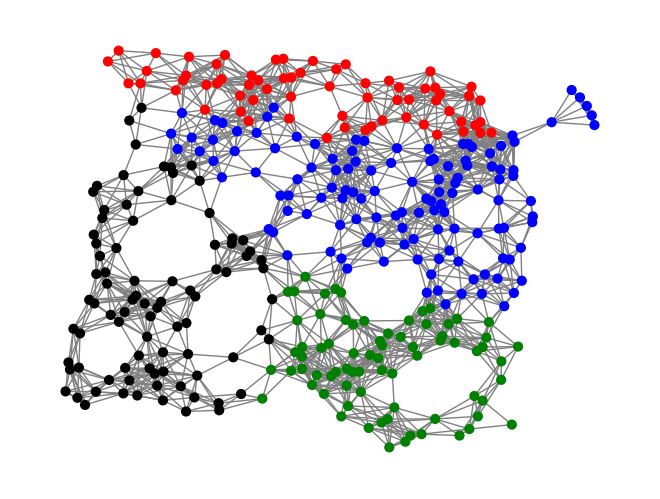

1

<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.random_geometric_graph(350, 0.115)

# (2) Run the clustering algorithm
graph_k_means = GraphKMeans(G,k=4,n_iter=10)               
d = graph_k_means.fit() # returns a dictionary with keys are nodes of the graph, values are id of the clusters

# (3) plot to inspect the clustering results
draw = graph_parition_plot(G,d)    
draw.draw_graph_partition()

# Refs 

(1) https://github.com/mhajij/Generalized_K-means_on_Graphs_Using_PageRank


(2) https://arxiv.org/pdf/2005.04774.pdf

